In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sp

Question 1(a)

In [ ]:
v = "/content/Voice.wav"

In [ ]:
from IPython.display import Audio
from IPython.core.display import display
from scipy.io import wavfile
#from IPython.display import clear_output
def playAudio():
    sound = wavfile.read(v)

    sound_data = sound[1]
    r = sound[0]
    t = np.arange(0,len(sound_data))/r

    display(Audio(sound_data.T,rate=r, autoplay=True))
    plt.xlabel("t")
    plt.ylabel("amplitude")
    plt.title("my voice")
    plt.plot(t,sound_data)
    plt.savefig("myvoice.png")
    plt.show()

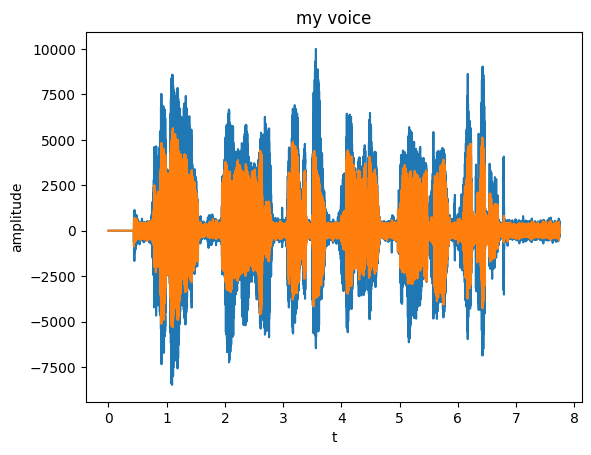

In [ ]:
playAudio()

In [ ]:
sound = wavfile.read(v)
sound_data = sound[1]
r = sound[0]
t = np.arange(0,len(sound_data))/r

In [ ]:
# from scipy.signal import resample
from scipy.signal.windows import hann
import math as m

In [ ]:
print(r)

48000


In [ ]:
sound_data = np.array(sound_data)
t_sr = 8000
t_s = int(len(sound_data)*t_sr/r)
a = sp.resample(sound_data, t_s)
sound_data = a[:,0]
r = t_sr
print(sound_data.shape)


(61952,)


In [ ]:
s = False
win = hann(m.floor(0.03*r),s)

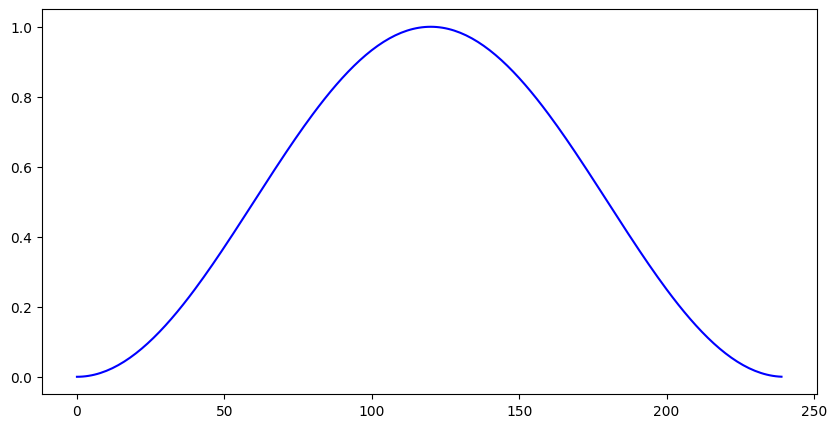

In [ ]:
# viewing window
k = np.array(range(m.floor(0.03*r)))

fig = plt.figure(figsize=(10, 5))
plt.plot(k, win, 'b')
plt.savefig("win.png")
plt.show()

In [ ]:
def c_overlap_b(x, w, R = 0.5):
    n = len(x)
    nw = len(w)
    s = m.floor(nw * (1 - R))
    nb = m.floor((n - nw) / s) + 1
    A = np.zeros((nb, nw))
    for i in range(nb):
        o_s = i * s
        A[i, :] = w * x[o_s : nw + o_s]
    return A

In [ ]:
def a_overlap_b(A, w, R = 0.5):
    [count, nw] = A.shape
    s = m.floor(nw * R)

    n = (count-1) * s + nw

    x = np.zeros((n, ))

    for i in range(count):
        o_s = i * s
        x[o_s : nw + o_s] += A[i, :]

    return x

In [ ]:
def m_mat_X(x, p):
    n = len(x)
    # [x_n, ..., x_1, 0, ..., 0]
    xz = np.concatenate([x[::-1], np.zeros(p)])

    X = np.zeros((n - 1, p))
    for i in range(n - 1):
        o_s = n - 1 - i
        X[i, :] = xz[o_s : o_s + p]
    return X

In [ ]:
def s_lpc(x, p, ii):
    b = x[1:]

    X = m_mat_X(x, p)

    a = np.linalg.lstsq(X, b.T)[0]

    e = b - np.dot(X, a)
    g = np.var(e)

    return [a, g]

In [ ]:
def lpc_encode(x, p, w):
    B = c_overlap_b(x, w)
    [nb, nw] = B.shape

    A = np.zeros((p, nb))
    G = np.zeros((1, nb))

    for i in range(nb):
        [a, g] = s_lpc(B[i, :], p, i)

        A[:, i] = a
        G[:, i] = g

    return [A, G]

In [ ]:
def r_s_f(a, g, block_size):
    src = np.sqrt(g)*np.random.randn(block_size, 1) # noise

    b = np.concatenate([np.array([-1]), a])

    x_hat = sp.lfilter([1], b.T, src.T).T

    # convert Nx1 matrix into a N vector
    return np.squeeze(x_hat)

In [ ]:
def lpc_decode(A, G, w, lowcut = 0):

    [ne, n] = G.shape
    nw = len(w)
    [p, _] = A.shape

    B_hat = np.zeros((n, nw))

    for i in range(n):
        B_hat[i,:] = r_s_f(A[:, i], G[:, i], nw)

    # recover signal from blocks
    x_hat = a_overlap_b(B_hat,w);

    return x_hat

In [ ]:
p = 48 # number of poles
[A, G] = lpc_encode(sound_data, p, win)

# Print stats
ori_size = len(sound_data)
mod_size = A.size + G.size
print('Original signal size:', ori_size)
print('Encoded signal size:', mod_size)
print('Data reduction:', ori_size/mod_size)

xhat = lpc_decode(A, G, win)

wavfile.write("reconstructed.wav", r, xhat)
print('done')


<ipython-input-16-b8022cbe4e08>:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  a = np.linalg.lstsq(X, b.T)[0]


Original signal size: 61952
Encoded signal size: 25235
Data reduction: 2.4550029720626116
done


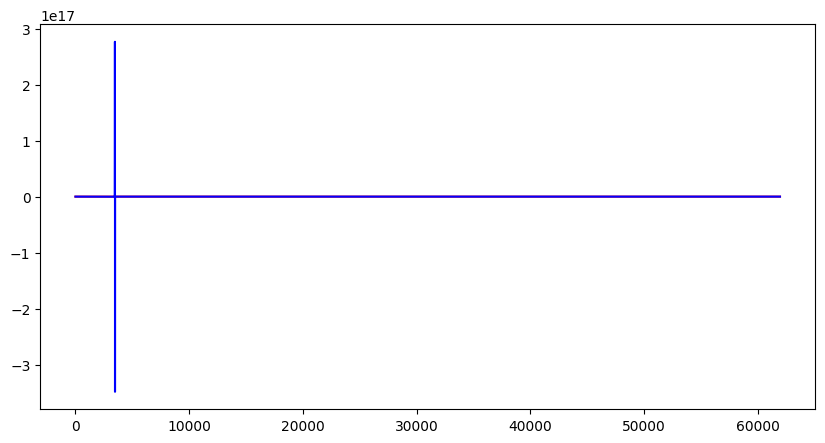

In [ ]:
fig = plt.figure(figsize=(10, 5))

n = len(sound_data)
ts = np.array(range(0, n))
plt.plot(ts, sound_data, 'r')

xhat_padded = np.concatenate([xhat, np.zeros(n - len(xhat))])
plt.plot(ts, xhat_padded, 'b')
plt.savefig("ovsd1.png")
plt.show()

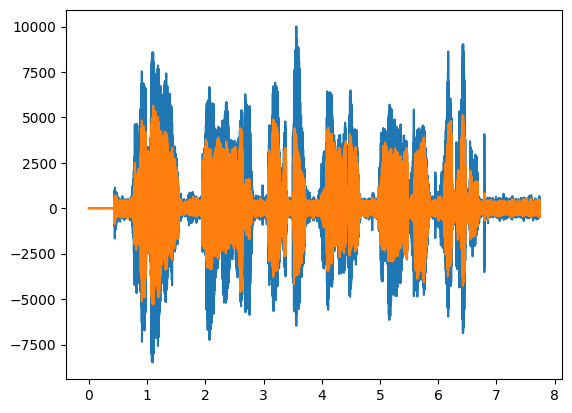

In [ ]:
m = "/content/reconstructed.wav"
c = wavfile.read(m)
d = sound[1]
e = sound[0]
f = np.arange(0,len(d))/e
display(Audio(d.T,rate=e, autoplay=True))
plt.plot(f,d)
plt.show()